# Simple regression demo

__Stephen David__

* Demonstrate basic methodologies for estimation of encoding models using a "toy",
  two-dimensional input space

* Input is Gaussian white noise, which can contain correlations between channels,
  mimicking the correlations that occur in natural sounds. (set correlated_inputs=True)

* The output can pass through a static nonlinearity, illustrating limitations of
  a completely linear model, especially in generalizing to stimuli outside of the
  space used for fitting. (set output_nonlinearity=True)

Load the relevant libraries for analysis and plotting. 
* Note that strflib is not a native python library. It is a python file located in this working directory that contains useful functions for this analysis. This is a nice way to store useful functions that you find yourself using often during your analyses.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import strflib  # some functions that support this notebook page

## Simulate data

Generates (input,output) data for a simple system with two inputs. 

y = x(1) * h(1) + x(2) * h(2)

h(1) and h(2) are weights applied to each input before summing to produce the output y.

optional parameters:
correlated_inputs=False   # should input channels be correlated?
output_nonlinearity=False   # static nonlinearity at output?
noise_amplitude=0.5 # how much noise (unpredictable activity) is present in the output

In [3]:
# define some global variables for the simulated data

# filter linear gain 
h1=np.array([[.5], [0]])
dimcount=len(h1)  # ie, two input channels
h0=np.zeros([1,1])

# parameters of static NL (if used)
sigmoid_parms=np.array([-1, 2.5, 0.5, 0.2])

# number of samples for estimation/testing
T=dimcount*100

def simulate_simple_data(correlated_inputs=False, output_nonlinearity=False, noise_amplitude=0.5,shifted_mean=False):

    if shifted_mean:
        # mean of input -- shifted for the "out of class" test set
        m=np.matrix([[3],[3]])
        if correlated_inputs:
            s=np.array([[0.4, 0.1], [0.1, 0.4]])
        else:
            s=np.array([[1.0,0],[0,1.0]])
    else:
        # mean of input
        m=np.zeros([dimcount,1])
        
        if correlated_inputs:
            # gaussian noise stimulus covariance matrix has non-zero off-diagonal terms
            s=np.array([[1.0, 0.7], [0.7, 1.0]])
        else:
            # gaussian noise stimulus covariance matrix has zero off-diagonal terms
            s=np.array([[1.0, 0], [0, 1.0]])
    
    # Generate the input and pass it through the linear filter based on above parameters
    x=strflib.gnoise(m,s,T)

    # linear filter
    y=np.matmul(h1.T,x)

    if output_nonlinearity:
        # pass output of filter through sigmoid (if specified)
        y=strflib.logsig_fn(sigmoid_parms,y)

    if noise_amplitude:
        # add noise (if specified)
        # gaussian additive noise
        y=y+strflib.gnoise(np.zeros([1,1]),np.matrix([[noise_amplitude]]),T)

    return x,y

## generate data without noise

In [4]:
(x,y)=simulate_simple_data(correlated_inputs=False, output_nonlinearity=False, noise_amplitude=0.0,shifted_mean=False)
print("x size: {0}".format(x.shape))
print("y size: {0}".format(y.shape))

print("weights applied to input: h[0]={0}, h[1]={1}".format(h1[0,0],h1[1,0]))

x size: (2, 200)
y size: (1, 200)
weights applied to input: h[0]=0.5, h[1]=0.0


Plot the data. Note that the output y tracks the first input

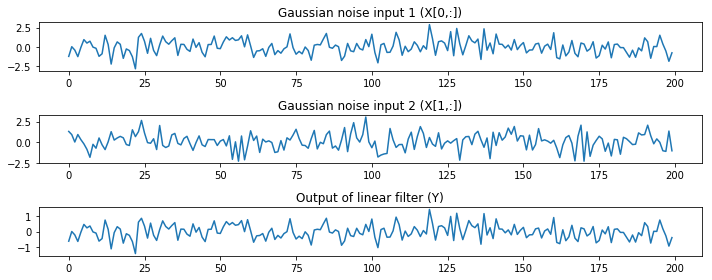

In [5]:
plt.figure(figsize=(10,4))
plt.subplot(311)
plt.plot(x[0,:])
plt.title('Gaussian noise input 1 (X[0,:])')

plt.subplot(312)
plt.plot(x[1,:])
plt.title('Gaussian noise input 2 (X[1,:])')

plt.subplot(313)
plt.plot(y[0,:])
plt.title('Output of linear filter (Y)')

plt.tight_layout()
plt.show()

## Generate a simple data set with noise
(No stimulus correlations, linear filter response, noise_amplitude=0.5)

In [289]:
(x_fit,y_fit)=simulate_simple_data(correlated_inputs=False, output_nonlinearity=False, noise_amplitude=0.5,shifted_mean=False)
print("fit data input (x_fit) size: {0}".format(x_fit.shape))
print("fit data output (y_fit) size: {0}".format(y_fit.shape))

fit data input (x_fit) size: (2, 200)
fit data output (y_fit) size: (1, 200)


note that the relationship between x and y is less clear

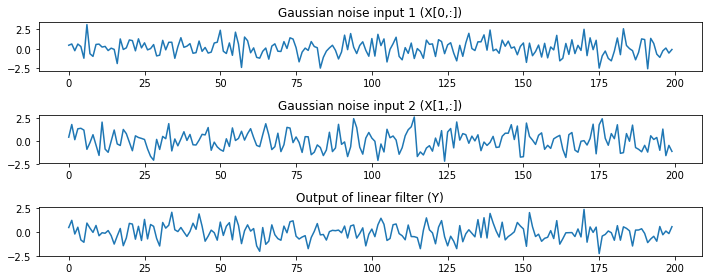

In [290]:
plt.figure(figsize=(10,4))
plt.subplot(311)
plt.plot(x_fit[0,:])
plt.title('Gaussian noise input 1 (X[0,:])')

plt.subplot(312)
plt.plot(x_fit[1,:])
plt.title('Gaussian noise input 2 (X[1,:])')

plt.subplot(313)
plt.plot(y_fit[0,:])
plt.title('Output of linear filter (Y)')

plt.tight_layout()
plt.show()

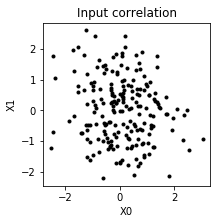

In [291]:
# plot X0 vs. X1 to illustrate stimulus autocorrelation (if specified)
plt.figure(figsize=(3,3))
plt.plot(x_fit[0,:],x_fit[1,:],'k.')
plt.xlabel('X0')
plt.ylabel('X1')
plt.title('Input correlation')
plt.show()

## Now, fit the model. Determine the filter that acted on the gaussian noise input to create the response above

In [292]:
# subtract mean from stimulus and response to make data well-behaved
mx=np.mean(x_fit,axis=1)
my=np.mean(y_fit,axis=1)
xx=x_fit-np.repeat(np.transpose(np.matrix(mx)),T,axis=1)
yy=y_fit-my

# stimulus-response correlation  STA = S * r
SR= np.matmul(xx, yy.T) / T

# stimulus autocorrelation
C= np.matmul(xx, xx.T) / T

# sta is normalized by stimulus variance
hsta= ((1/np.diag(C)) * np.array(SR.T)).T

In [293]:
# slope of true underlying system
xr=np.array([[np.min(x_fit[0,:])],[np.max(x_fit[0,:])]])
yr0=xr * h1[0,0] + h0
yr1=xr * h1[1,0] + h0

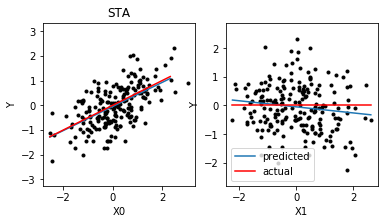

In [294]:
# STA results
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(x_fit[0,:],y_fit[0,:],'k.')
xr=np.array([[np.min(x_fit[0,:])],[np.max(y_fit[0,:])]])
yr=xr * hsta[0,0] + my
plt.plot(xr,yr,'-')
yr0=xr * h1[0,0] + h0
plt.plot(xr,yr0,'r-')
plt.title('STA')
plt.xlabel('X0')
plt.ylabel('Y')
plt.axis('equal')

plt.subplot(1,2,2)
plt.plot(x_fit[1,:],y_fit[0,:],'k.')
xr=np.array([[np.min(x_fit[1,:])],[np.max(x_fit[1,:])]])
yr=xr * hsta[1,0] + my
pred,=plt.plot(xr,yr,'-',label="predicted")
actual,=plt.plot(xr,yr1,'r-',label="actual")
plt.xlabel('X1')
plt.ylabel('Y')
plt.legend(handles=[pred,actual])
plt.axis('equal')
plt.tight_layout
plt.show()

## Example where inputs are correlated

In [295]:
# generate data with correlated_inputs=True
(x_cor,y_cor)=simulate_simple_data(correlated_inputs=True, output_nonlinearity=False, noise_amplitude=0.5,shifted_mean=False)


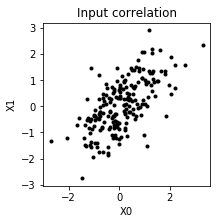

In [296]:
# plot X0 vs. X1 to illustrate stimulus autocorrelation (if specified)
plt.figure(figsize=(3,3))
plt.plot(x_cor[0,:],x_cor[1,:],'k.')
plt.xlabel('X0')
plt.ylabel('X1')
plt.title('Input correlation')
plt.show()

Try simple reverse correlation

In [297]:
# subtract mean from stimulus and response to make data well-behaved
mx=np.mean(x_cor,axis=1)
my=np.mean(y_cor,axis=1)
xx=x_cor-np.repeat(np.transpose(np.matrix(mx)),T,axis=1)
yy=y_cor-my

# stimulus-response correlation  STA = S * r
SR= np.matmul(xx, yy.T) / T

# stimulus autocorrelation
C= np.matmul(xx, xx.T) / T

# sta is normalized by stimulus variance
hsta= ((1/np.diag(C)) * np.array(SR.T)).T

print("hsta={0}".format(hsta))

hsta=[[ 0.50217504]
 [ 0.2546718 ]]


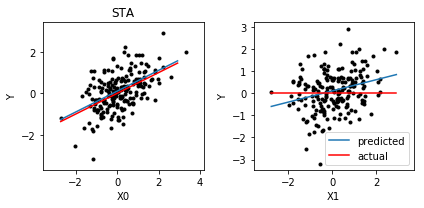

In [298]:
# STA results
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(x_cor[0,:],y_cor[0,:],'k.')
xr=np.array([[np.min(x_cor[0,:])],[np.max(y_cor[0,:])]])
yr=xr * hsta[0,0] + my
plt.plot(xr,yr,'-')
yr0=xr * h1[0,0] + h0
plt.plot(xr,yr0,'r-')
plt.title('STA')
plt.xlabel('X0')
plt.ylabel('Y')
plt.axis('equal')

plt.subplot(1,2,2)
plt.plot(x_cor[1,:],y_cor[0,:],'k.')
xr=np.array([[np.min(x_cor[1,:])],[np.max(x_cor[1,:])]])
yr=xr * hsta[1,0] + my
pred,=plt.plot(xr,yr,'-',label="predicted")
actual,=plt.plot(xr,yr1,'r-',label="actual")
plt.xlabel('X1')
plt.ylabel('Y')
plt.legend(handles=[pred,actual])
plt.axis('equal')
plt.tight_layout()
plt.show()

In [299]:
# estimate filter using normalized reverse correlation (aka linear regression)
Cinv=np.linalg.inv(C)
hnrc= np.matmul(Cinv, SR)

print("hnrc={0}".format(hnrc))

hnrc=[[ 0.56047654]
 [-0.08626497]]


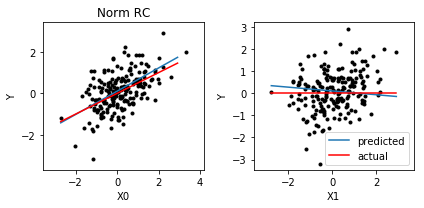

In [300]:
# NRC results
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(x_cor[0,:],y_cor[0,:],'k.')
xr=np.array([[np.min(x_cor[0,:])],[np.max(y_cor[0,:])]])
yr=xr * hnrc[0,0] + my
plt.plot(xr,yr,'-')
yr0=xr * h1[0,0] + h0
plt.plot(xr,yr0,'r-')
plt.title('Norm RC')
plt.xlabel('X0')
plt.ylabel('Y')
plt.axis('equal')

plt.subplot(1,2,2)
plt.plot(x_cor[1,:],y_cor[0,:],'k.')
xr=np.array([[np.min(x_cor[1,:])],[np.max(x_cor[1,:])]])
yr=xr * hnrc[1,0] + my
pred,=plt.plot(xr,yr,'-',label="predicted")
actual,=plt.plot(xr,yr1,'r-',label="actual")
plt.xlabel('X1')
plt.ylabel('Y')
plt.legend(handles=[pred,actual])
plt.axis('equal')
plt.tight_layout()
plt.show()

In [301]:
# estimate filter using coordinate descent (aka boosting)
(hcd,hcd0)=strflib.coordinate_descent(x_cor,y_cor,0)

starting CD: n_params=2, step size: 0.100000 tolerance: 0.000100
1: best step=0,0 error=0.9014394146057818, delta=0.09856058539421819
2: best step=0,0 error=0.824675827501631, delta=0.07676358710415077
3: best step=0,0 error=0.7697092386875486, delta=0.05496658881408245
4: best step=0,0 error=0.7365396481635341, delta=0.03316959052401447
5: best step=0,0 error=0.7251670559295877, delta=0.011372592233946377
6: Backwards (delta=-0.00012660408701847814), adjusting step size to 0.05
7: best step=1,1 error=0.7222031969953289, delta=0.0030904630212773565
8: best step=0,0 error=0.7210079431398712, delta=0.001195253855457712
9: best step=1,1 error=0.7204155740638882, delta=0.0005923690759829237
10: Backwards (delta=-0.0005711636197990311), adjusting step size to 0.025
11: best step=1,0 error=0.7199549683574376, delta=0.0010317693262497096
12: Backwards (delta=-0.00046060570645067855), adjusting step size to 0.0125
13: best step=1,1 error=0.7199960736495523, delta=0.000419500414335916
14: best 

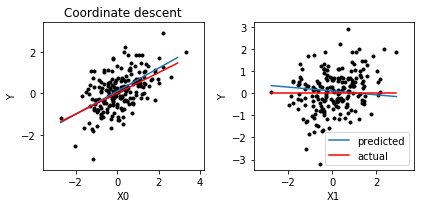

In [302]:
# Coordinate descent results
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(x_cor[0,:],y_cor[0,:],'k.')
xr=np.array([[np.min(x_cor[0,:])],[np.max(y_cor[0,:])]])
yr=xr * hcd[0,0] + my
plt.plot(xr,yr,'-')
yr0=xr * h1[0,0] + h0
plt.plot(xr,yr0,'r-')
plt.title('Coordinate descent')
plt.xlabel('X0')
plt.ylabel('Y')
plt.axis('equal')

plt.subplot(1,2,2)
plt.plot(x_cor[1,:],y_cor[0,:],'k.')
xr=np.array([[np.min(x_cor[1,:])],[np.max(x_cor[1,:])]])
yr=xr * hcd[1,0] + my
pred,=plt.plot(xr,yr,'-',label="predicted")
actual,=plt.plot(xr,yr1,'r-',label="actual")
plt.xlabel('X1')
plt.ylabel('Y')
plt.legend(handles=[pred,actual])
plt.axis('equal')
plt.tight_layout()
plt.show()

## Nonlinear system

In [311]:
# parameters of static NL (if used)
sigmoid_parms=np.array([-1, 3, 0.75, 0.1])

(x_nl,y_nl)=simulate_simple_data(correlated_inputs=True, output_nonlinearity=True, noise_amplitude=0.05,shifted_mean=False)
(x_out,y_out)=simulate_simple_data(correlated_inputs=True, output_nonlinearity=True, noise_amplitude=0.05,shifted_mean=True)


In [312]:
# subtract mean from stimulus and response to make data well-behaved
mx=np.mean(x_nl,axis=1)
my=np.mean(y_nl,axis=1)
xx=x_cor-np.repeat(np.transpose(np.matrix(mx)),T,axis=1)
yy=y_cor-my

# stimulus-response correlation  STA = S * r
SR= np.matmul(xx, yy.T) / T

# stimulus autocorrelation
C= np.matmul(xx, xx.T) / T

# sta is normalized by stimulus variance
hsta= ((1/np.diag(C)) * np.array(SR.T)).T

print("hsta={0}".format(hsta))

# estimate filter using normalized reverse correlation (aka linear regression)
Cinv=np.linalg.inv(C)
hnrc= np.matmul(Cinv, SR)

print("hnrc={0}".format(hnrc))


hsta=[[ 0.52196143]
 [ 0.23944279]]
hnrc=[[ 0.61096845]
 [-0.13184982]]


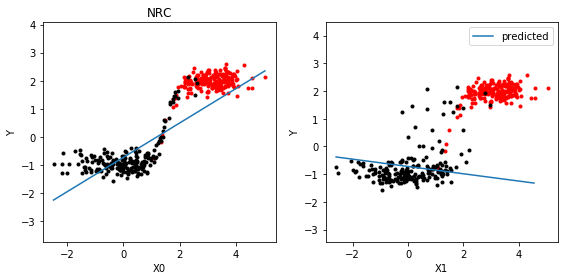

In [313]:
# NRC results
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(x_out[0,:],y_out[0,:],'r.')
plt.plot(x_nl[0,:],y_nl[0,:],'k.')
xr=np.array([[np.min(x_nl[0,:])],[np.max(x_out[0,:])]])
yr=xr * hnrc[0,0] + my
plt.plot(xr,yr,'-')
yr0=xr * h1[0,0] + h0
#plt.plot(xr,yr0,'r-')
plt.title('NRC')
plt.xlabel('X0')
plt.ylabel('Y')
plt.axis('equal')

plt.subplot(1,2,2)
plt.plot(x_out[0,:],y_out[0,:],'r.')
plt.plot(x_nl[1,:],y_nl[0,:],'k.')
xr=np.array([[np.min(x_nl[1,:])],[np.max(x_out[1,:])]])
yr=xr * hnrc[1,0] + my
pred,=plt.plot(xr,yr,'-',label="predicted")
#actual,=plt.plot(xr,yr1,'r-',label="actual")
plt.xlabel('X1')
plt.ylabel('Y')
plt.legend(handles=[pred])
plt.axis('equal')
plt.tight_layout()
plt.show()

Compare error for "in" vs. "out" data

In [314]:
my=np.mean(y_nl)
predicted_nl=np.matmul(hnrc.T,x_nl)+my
predicted_out=np.matmul(hnrc.T,x_out)+my

error_nl=np.square(y_nl-predicted_nl)
error_out=np.square(y_out-predicted_out)
me_nl=np.mean(error_nl)
me_out=np.mean(error_out)

print("Mean squared error in={0} out={1}".format(me_nl,me_out))


Mean squared error in=0.3166023901699052 out=1.543591139421269
